In [1]:
import pandas as pd
import os
import random
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import BCELoss

from common_stuff import TextPicDataset
from common_stuff import device, load_convnext_model, load_effnet_model, load_convbert_model

from sklearn.model_selection import train_test_split

def get_metrics(targets, predictions):
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    logloss = BCELoss()(np.clip(targets, 1e-15, 1-1e-15), np.clip(predictions, 1e-15, 1-1e-15))
    return mse, mae, logloss.item()  

In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
effnet_paths = ["../../effnet_MSE.pth", "../../effnet_BCE.pth", "../../effnet_BCEWeighted_2.pth", "../../effnet_BCEWeighted_3.pth", "../../effnet_BCEWeighted_4.pth"]
convnext_paths = ["../../convnext_MSE.pth", "../../convnext_BCE.pth", "../../convnext_BCEWeighted_2.pth", "../../convnext_BCEWeighted_3.pth", "../../convnext_BCEWeighted_4.pth"]
picture_paths = [effnet_paths, convnext_paths]

bert_paths = [["../../convbert_BCE.pth", "../../convbert_BCEWeighted_2.pth", "../../convbert_BCEWeighted_3.pth", "../../convbert_BCEWeighted_4.pth"]]

def split_post(cell):
    return str(cell["text"]).split()
df = pd.read_csv("../../post2ctr_dataset.csv")
df["splitted"] = df.apply(split_post, axis=1)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)

max_size = 224
transform = transforms.Compose([
    transforms.Resize((max_size, max_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
test_dataset = TextPicDataset(test_df, tokenizer=tokenizer, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/home/vivy/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


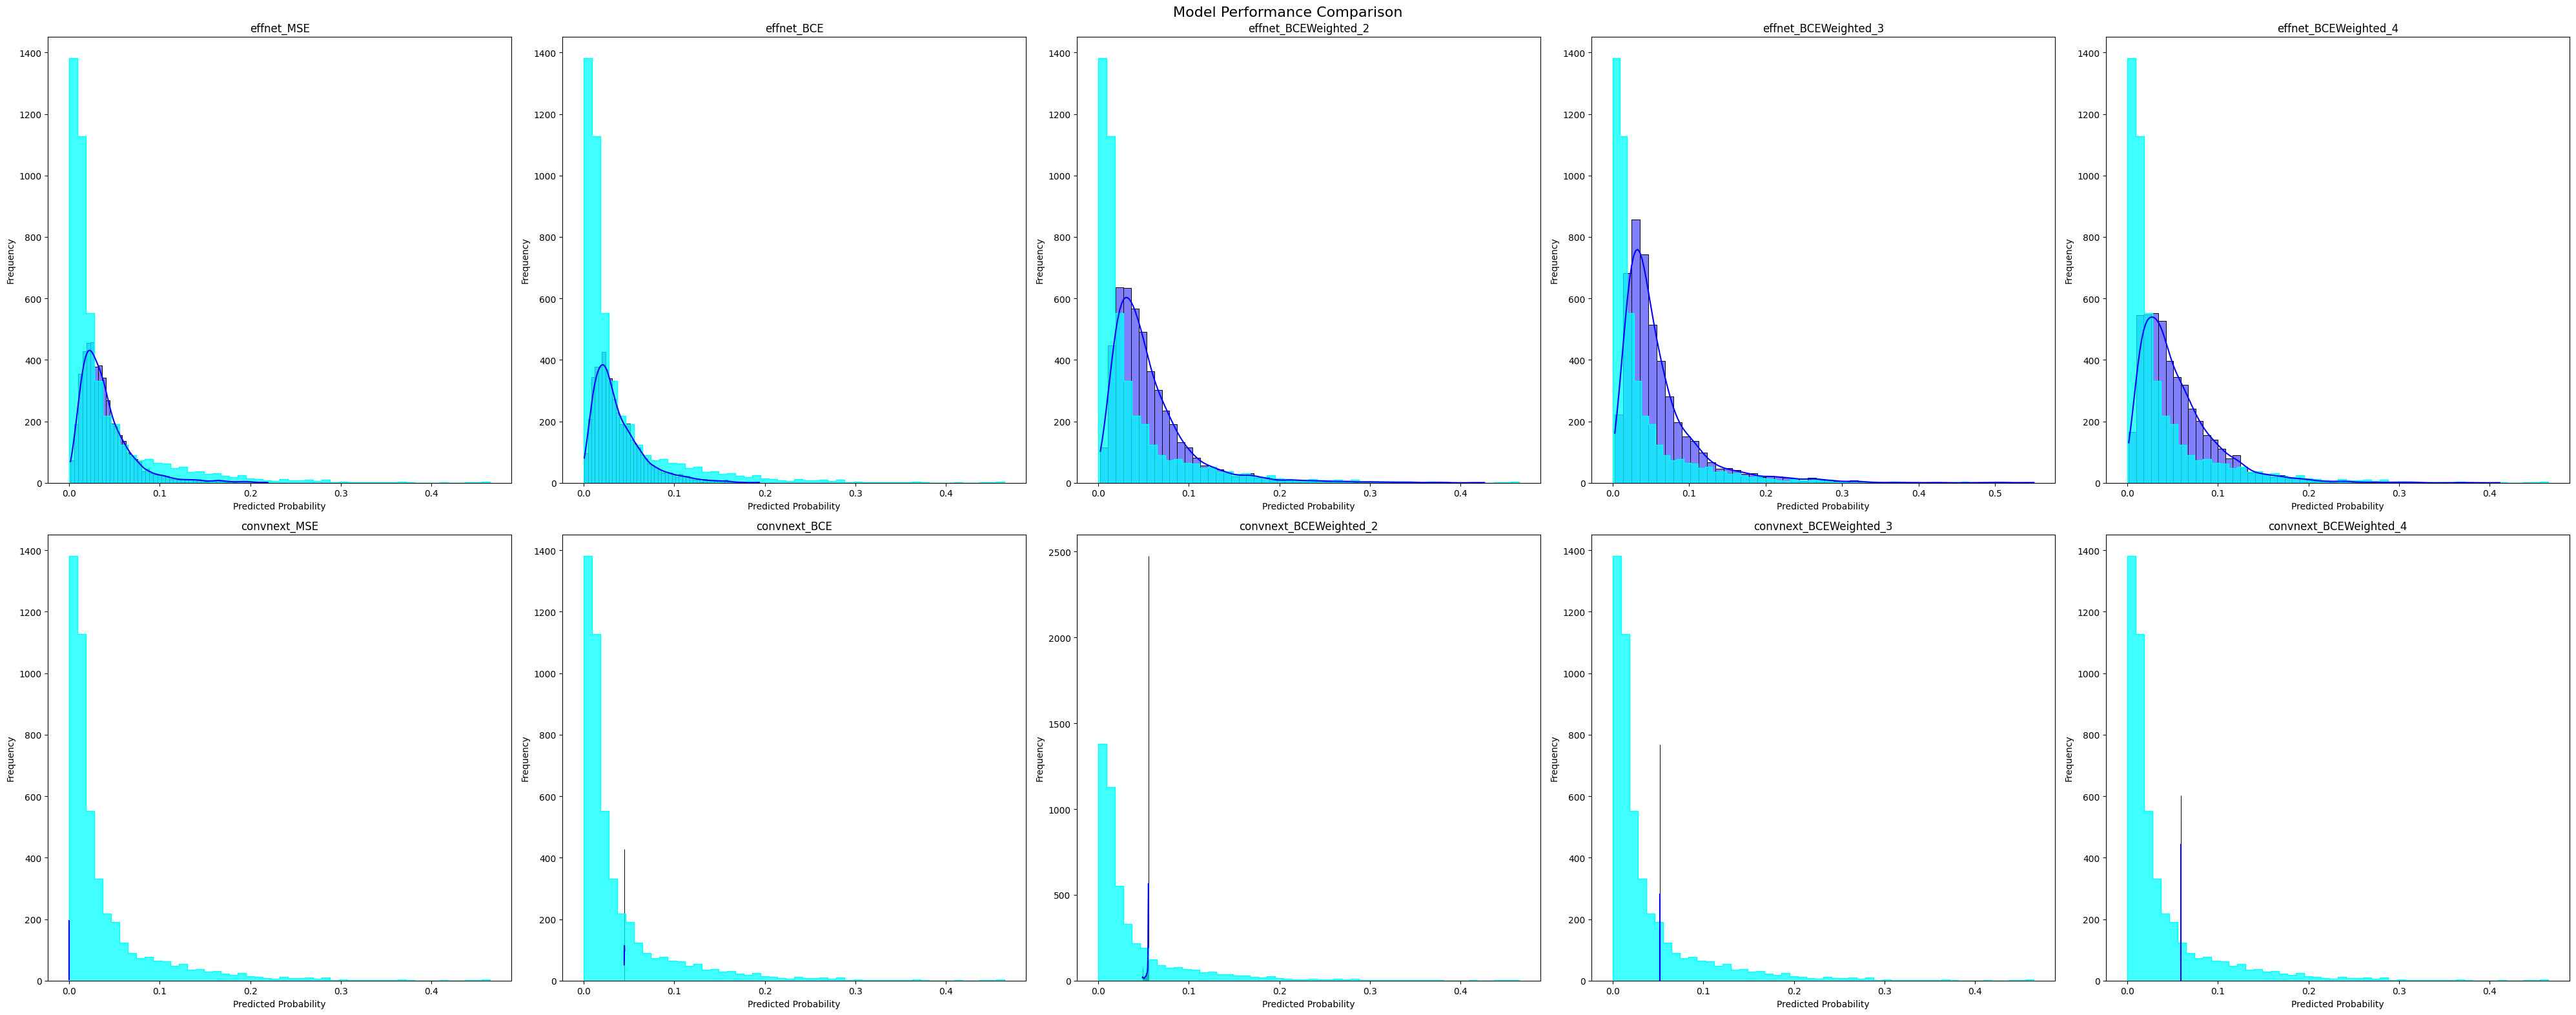

                    Model       MSE       MAE   Logloss
0              effnet_MSE  0.002889  0.033859  0.209891
1              effnet_BCE  0.002856  0.033031  0.200276
2    effnet_BCEWeighted_2  0.004170  0.043823  0.286783
3    effnet_BCEWeighted_3  0.005185  0.047315  0.306159
4    effnet_BCEWeighted_4  0.003910  0.042890  0.277570
5            convnext_MSE  0.004318  0.037764  0.040280
6            convnext_BCE  0.002942  0.038744  0.251495
7  convnext_BCEWeighted_2  0.003175  0.044241  0.297262
8  convnext_BCEWeighted_3  0.003098  0.042762  0.285593
9  convnext_BCEWeighted_4  0.003340  0.046920  0.317591


In [4]:
fig, axes = plt.subplots(2, 5, figsize=(40, 16))
fig.suptitle("Model Performance Comparison", fontsize=16)
metrics_results = []

for i, model_paths_group in enumerate(picture_paths):
    for j, model_path in enumerate(model_paths_group):
        model = None
        if i == 0:
            model = load_effnet_model(model_path)
        else:
            model = load_convnext_model(model_path)
        model = model.to(device)
        name = model_path[6:-4]

        preds, targets = [], []
        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loader, 0):
                inputs = data["img"].to(device)
                target = data["target"].to(device, dtype=torch.float)
                outputs = model(inputs)

                preds.append(outputs)
                targets.append(target)
        targets = torch.cat(targets, dim=0).squeeze().cpu()
        preds = torch.cat(preds, dim=0).squeeze().cpu()
        mse, mae, logloss = get_metrics(targets, preds)

        sns.histplot(preds, bins=50, color="blue", kde=True, label="Predictions", ax=axes[i, j])
        sns.histplot(targets, bins=50, color="cyan", kde=False, label="Actual", ax=axes[i, j], element="step")
        
        axes[i, j].set_title(f"{name}")
        axes[i, j].set_xlabel("Predicted Probability")
        axes[i, j].set_ylabel("Frequency")

        metrics_results.append({
            "Model": name,
            "MSE": mse,
            "MAE": mae,
            "Logloss": logloss
        })

metrics_df = pd.DataFrame(metrics_results)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

print(metrics_df)

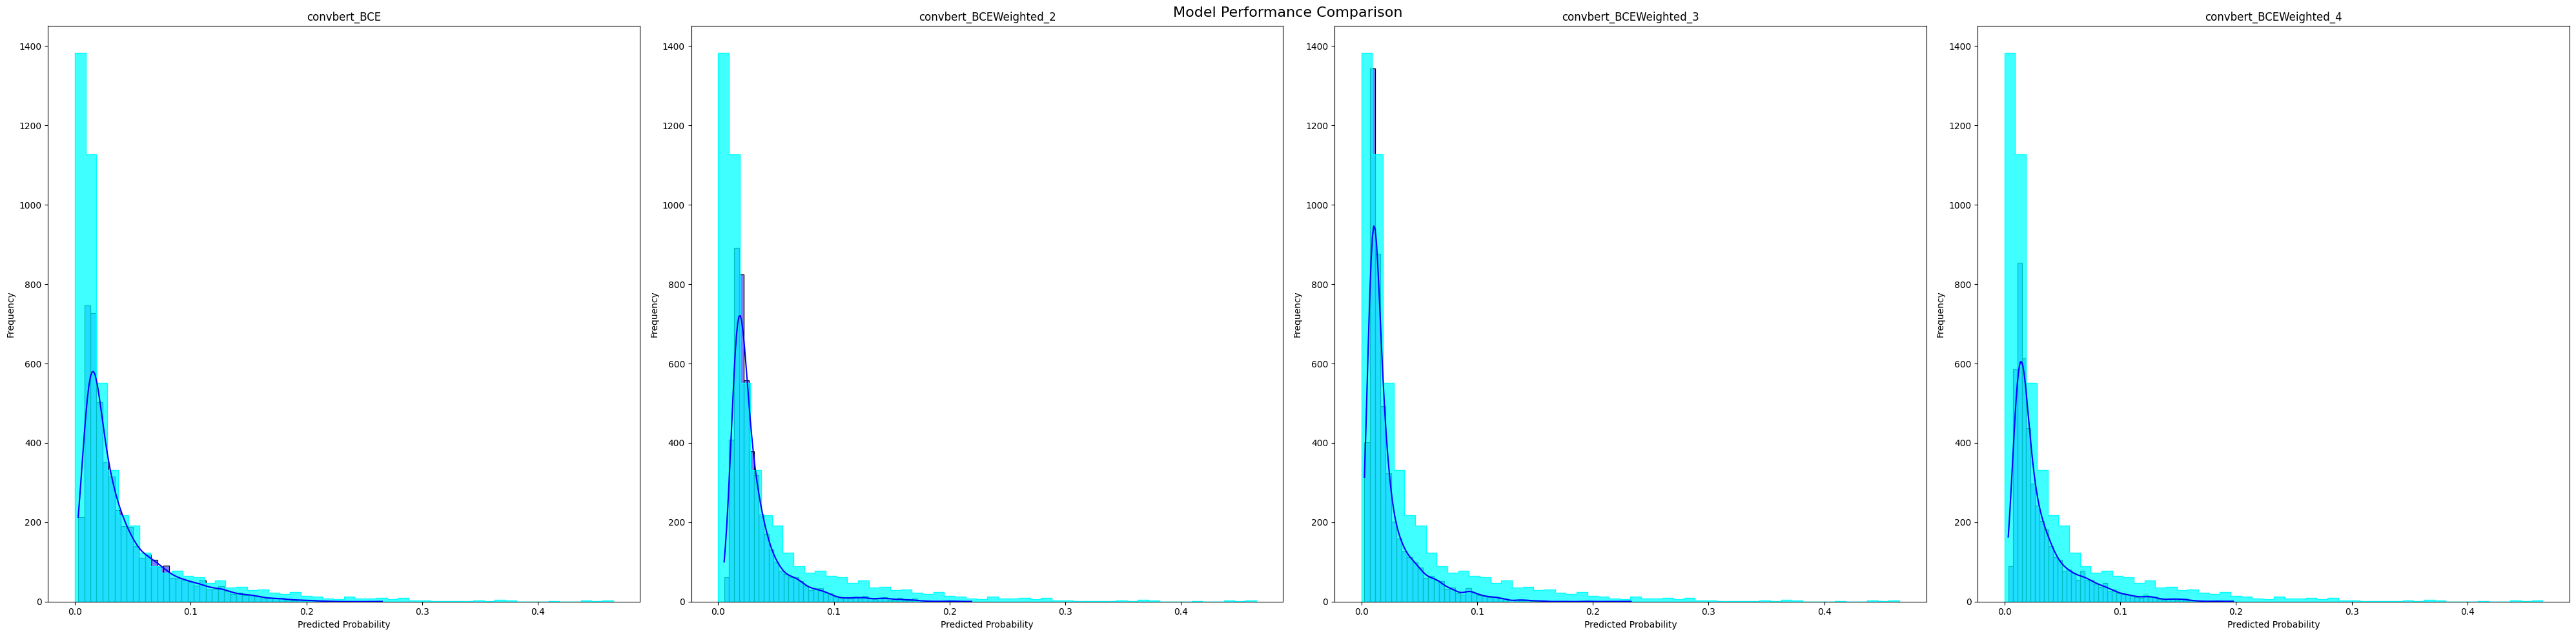

                    Model       MSE       MAE   Logloss
0            convbert_BCE  0.003113  0.034377  0.203064
1  convbert_BCEWeighted_2  0.002983  0.031512  0.178892
2  convbert_BCEWeighted_3  0.003039  0.029984  0.140428
3  convbert_BCEWeighted_4  0.002896  0.031256  0.170450


In [7]:
fig, axes = plt.subplots(1, 4, figsize=(40, 10))
fig.suptitle("Model Performance Comparison", fontsize=16)
metrics_results = []

for i, model_paths_group in enumerate(bert_paths):
    for j, model_path in enumerate(model_paths_group):
        model = load_convbert_model(model_path)
        model = model.to(device)
        name = model_path[6:-4]
        preds, targets = [], []
        model.eval()
        with torch.no_grad():
            for data in test_loader:
                inputs = data["img"].to(device)
                ids = data["input_ids"].to(device, dtype=torch.long)
                mask = data["attention_mask"].to(device, dtype=torch.long)
                token_ids = data["token_type_ids"].to(device, dtype=torch.long)
                target = data["target"].to(device, dtype=torch.float)
                outputs = model(ids, mask, token_ids, inputs)

                preds.append(outputs)
                targets.append(target)
                
        targets = torch.cat(targets, dim=0).squeeze().cpu()
        preds = torch.cat(preds, dim=0).squeeze().cpu()
        mse, mae, logloss = get_metrics(targets, preds)

        sns.histplot(preds, bins=50, color="blue", kde=True, label="Predictions", ax=axes[j])
        sns.histplot(targets, bins=50, color="cyan", kde=False, label="Actual", ax=axes[j], element="step")
        
        axes[j].set_title(f"{name}")
        axes[j].set_xlabel("Predicted Probability")
        axes[j].set_ylabel("Frequency")

        metrics_results.append({
            "Model": name,
            "MSE": mse,
            "MAE": mae,
            "Logloss": logloss
        })

metrics_df = pd.DataFrame(metrics_results)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

print(metrics_df)

Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

tensor([0.0193, 0.1512, 0.1035, 0.0051, 0.0136, 0.0188, 0.0083, 0.0148],
       device='cuda:0')
tensor([0.0107, 0.0157, 0.0437, 0.0074, 0.0133, 0.0651, 0.0104, 0.0091],
       device='cuda:0')
tensor([0.0223, 0.0235, 0.0969, 0.0115, 0.0254, 0.0231, 0.0122, 0.0213],
       device='cuda:0')
Child turned into a titty &#128557;
Вот такая натуральная красота
На этой неделе в нашей школе - студии прошли сборы, которые продлились четыре дня&#33;<br>Дети усердно трудились все это время, за что получили сладкую награду) <br>Спасибо, [club211514738|@bonneville_cafe] &#129293;<br>В последний день сборов ребята выступали с номерами, которые поставили сами&#33;<br>Предлагаем окунуться в эту невероятно уютную атмосферу и посмотреть номера «Миньоны на каникулах», «Осенний разбой», «Барбимания» и  «Холод» вместе с нами)
Бывший депутат городской думы Мегиона Лечи Арсаев получил шесть лет колонии за взятку. При этом ранее Арсаев должен был лишь выплатить штраф в три миллиона рублей по решению суда перв

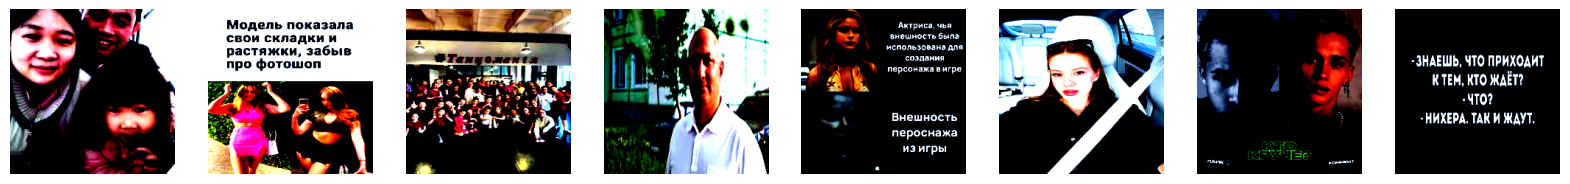

In [7]:
effnet = load_effnet_model("../../effnet_BCE.pth")
effnet = effnet.to(device)
effnet.eval()
convbert = load_convbert_model("../../convbert_BCEWeighted_3.pth")
convbert = convbert.to(device)
convbert.eval()

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader, 0):
        if batch_idx != 30:
            continue
        images = data["img"].to(device)
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_ids = data["token_type_ids"].to(device, dtype=torch.long)
        targets = data["target"].to(device, dtype=torch.float).squeeze()
        outputs_effnet = effnet(images).squeeze()
        outputs_convbert = convbert(ids, mask, token_ids, images).squeeze()

        images = images.permute(0, 2, 3, 1).cpu().numpy()
        fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
        print(outputs_effnet)
        print(outputs_convbert)
        print(targets)

        for i, img in enumerate(images):
            axs[i].imshow(img)
            axs[i].axis('off')
            print(test_df.iloc[8 * batch_idx + i]["text"])
        break